<a href="https://colab.research.google.com/github/rayen03/Tumor-Detect/blob/main/Tumor-Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports

import tensorflow as tf
import os
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from keras.src.metrics.confusion_metrics import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout,Activation
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataDir='/content/drive/MyDrive/Data'
train_folder ='/content/drive/MyDrive/Data/train'
valid_folder = '/content/drive/MyDrive/Data/valid'
test_folder = '/content/drive/MyDrive/Data/test'
print(os.listdir(dataDir))
Cclasses = os.listdir(test_folder)
Cclasses

['test', 'train', 'valid']


['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Data control

In [ ]:

#deleting corrupted files

def filter_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)

            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                try:

                    with Image.open(file_path) as img:
                        img.verify()
                except OSError:

                    print(f"Removing: {file_path}")
                    os.remove(file_path)
            else:

                print(f"Removing: {file_path} - Unsupported file type")
                os.remove(file_path)

filter_images(test_folder)
filter_images(train_folder)
filter_images(valid_folder)


In [ ]:



# Function to count the number of files in a folder
def count_files(folder_path):
    try:
        with os.scandir(folder_path) as entries:
            return sum(1 for entry in entries if entry.is_file() and not entry.name.startswith('.'))
    except OSError as e:
        print(f"Error counting files in {folder_path}: {e}")
        return 0

# Function to calculate the percentage of files in a folder
def calculate_percentage(folder_path, total_files):
    folder_files = count_files(folder_path)
    return (folder_files / total_files) * 100 if total_files > 0 else 0

# Iterate through test, train, and valid folders
for folder in [test_folder, train_folder, valid_folder]:
    total_files = sum([count_files(os.path.join(folder, class_name)) for class_name in Cclasses])

    print(f"Folder: {folder}")
    for class_name in Cclasses:
        class_folder = os.path.join(folder, class_name)
        class_count = count_files(class_folder)
        class_percentage = calculate_percentage(class_folder, total_files)
        print(f"  Class: {class_name} - Count: {class_count} - Percentage: {class_percentage:.2f}%")

    print(f"  Total Files: {total_files}")
    print()



Folder: /content/drive/MyDrive/Data/test
  Class: adenocarcinoma - Count: 62 - Percentage: 30.24%
  Class: large.cell.carcinoma - Count: 40 - Percentage: 19.51%
  Class: normal - Count: 38 - Percentage: 18.54%
  Class: squamous.cell.carcinoma - Count: 65 - Percentage: 31.71%
  Total Files: 205

Folder: /content/drive/MyDrive/Data/train
  Class: adenocarcinoma - Count: 230 - Percentage: 33.92%
  Class: large.cell.carcinoma - Count: 114 - Percentage: 16.81%
  Class: normal - Count: 154 - Percentage: 22.71%
  Class: squamous.cell.carcinoma - Count: 180 - Percentage: 26.55%
  Total Files: 678

Folder: /content/drive/MyDrive/Data/valid
  Class: adenocarcinoma - Count: 23 - Percentage: 33.82%
  Class: large.cell.carcinoma - Count: 17 - Percentage: 25.00%
  Class: normal - Count: 13 - Percentage: 19.12%
  Class: squamous.cell.carcinoma - Count: 15 - Percentage: 22.06%
  Total Files: 68



# Model

In [3]:

#buiding generators
basic_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)
#data gen
train_data = train_gen.flow_from_directory(
    train_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

valid_data = basic_gen.flow_from_directory(
    valid_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = basic_gen.flow_from_directory(
    test_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = True
)



Found 678 images belonging to 4 classes.
Found 68 images belonging to 4 classes.
Found 205 images belonging to 4 classes.


In [ ]:
#building model

input_shape=(224,224,3)

base_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)

#freezing layers to use the model as feature extractor
for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(4,activation = 'softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                         

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001
)
model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    reduce_lr
]
results = model.fit(train_data, validation_data=valid_data, epochs=120, verbose=1)


Epoch 1/120
43/43 [==============================] - 18s 353ms/step - loss: 1.6806 - accuracy: 0.3938 - val_loss: 1.2378 - val_accuracy: 0.3824
Epoch 2/120
43/43 [==============================] - 15s 343ms/step - loss: 1.1867 - accuracy: 0.4587 - val_loss: 1.1577 - val_accuracy: 0.3676
Epoch 3/120
43/43 [==============================] - 15s 355ms/step - loss: 1.0713 - accuracy: 0.5029 - val_loss: 1.1766 - val_accuracy: 0.3824
Epoch 4/120
43/43 [==============================] - 15s 354ms/step - loss: 0.9818 - accuracy: 0.5221 - val_loss: 1.0206 - val_accuracy: 0.4853
Epoch 5/120
43/43 [==============================] - 15s 351ms/step - loss: 1.0018 - accuracy: 0.5560 - val_loss: 0.9896 - val_accuracy: 0.5000
Epoch 6/120
43/43 [==============================] - 15s 338ms/step - loss: 0.9983 - accuracy: 0.5324 - val_loss: 1.0348 - val_accuracy: 0.4853
Epoch 7/120
43/43 [==============================] - 15s 351ms/step - loss: 0.8685 - accuracy: 0.6121 - val_loss: 0.9840 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/ModelData')

In [4]:

Tumour_detect = load_model('/content/drive/MyDrive/ModelData')


In [ ]:
loss, acc = Tumour_detect.evaluate(test_data,verbose = 1)

13/13 [==============================] - 2s 141ms/step - loss: 0.3529 - accuracy: 0.8878


# Evaluation

In [5]:
#imports
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import seaborn as sns
import numpy as np
import cv2


13/13 [==============================] - 51s 4s/step


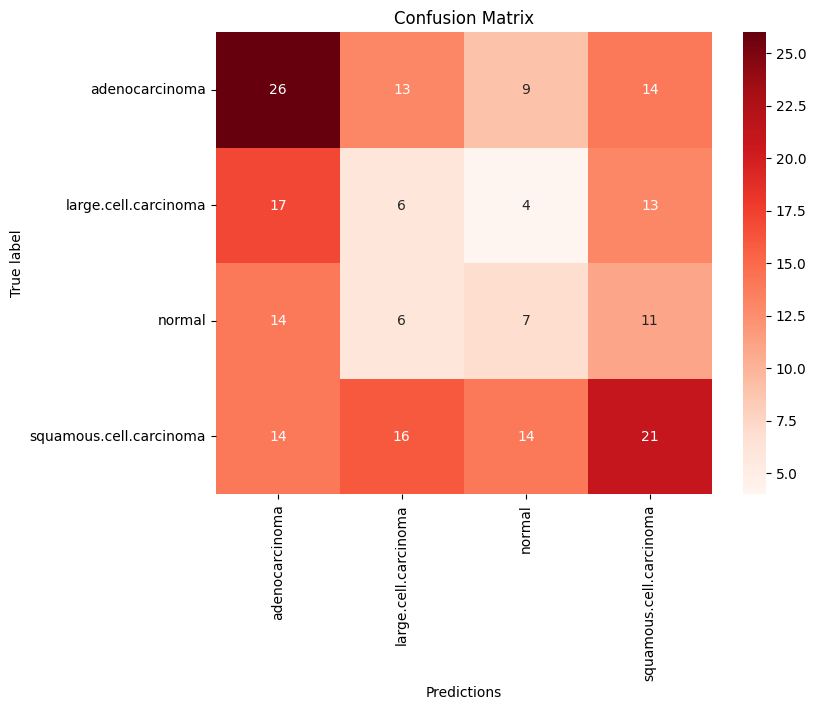

In [7]:
predictions_prob = Tumour_detect.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
plt.figure(figsize=(8, 6))
conf_mat = confusion_matrix(true_label, predictions)
sns.heatmap(conf_mat, fmt='g', annot=True, cmap='Reds', xticklabels=Cclasses, yticklabels=Cclasses)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()